![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+GenAI%2FEmbeddings&file=Bring+Embeddings+to+Life+With+Visualization+Techniques.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Embeddings/Bring%20Embeddings%20to%20Life%20With%20Visualization%20Techniques.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520GenAI%2FEmbeddings%2FBring%2520Embeddings%2520to%2520Life%2520With%2520Visualization%2520Techniques.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Embeddings/Bring%20Embeddings%20to%20Life%20With%20Visualization%20Techniques.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20GenAI/Embeddings/Bring%20Embeddings%20to%20Life%20With%20Visualization%20Techniques.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Bring Embeddings to Life With Visualization Techniques

- single or a few embeddings in heat map
- redimension with t-sne, PCA
- embeddings project local
- embeddings projector tool with GitHub data

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [104]:
# tuples of (import name, install name, min_version)
packages = [
    ('numpy', 'numpy'),
    ('tensorflow', 'tensorflow'), # , '2.17.0'
    ('tensorboard', 'tensorboard'), # , '2.18.0'
    ('matplotlib', 'matplotlib'), 
    ('seaborn', 'seaborn'),
    ('pandas', 'pandas'),
    ('sklearn', 'scikit-learn'),
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [96]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

inputs:

In [97]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [98]:
REGION = 'us-central1'
SERIES = 'applied-genai'
EXPERIMENT = 'visualize-embeddings'

packages:

In [108]:
import os, shutil
import json
import base64, io

import sklearn.manifold
import sklearn.decomposition
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import PIL.Image

import tensorflow as tf
from tensorboard.plugins import projector

In [8]:
%load_ext tensorboard

clients:

Parameters:

In [9]:
DIR = f"files/{EXPERIMENT}"

Environment:

In [10]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## Text & Images With Embeddings For Examples

This repository contains a [section for generation tasks](../Generate/readme.md) that includes image generation with [Vertex AI Imagen For Image Generation](../Generate/Vertex%20AI%20Imagen%20For%20Image%20Generation.ipynb).  The text and images from that project were also used to create multimodal embeddings in the [Vertex AI Multimodal Embeddings](./Vertex%20AI%20Multimodal%20Embeddings.ipynb) workflow.  The data generated for the multimodal embeddings is stored directly in the repository as a JSONL file of breed information for dogs, base64 encoded images, and embeddings for both text and images.  

The following code makes sure the data is local and downloads it from GitHub if missing.  Then it loads the JSONL data for use within this workflow.

### Get The Documents

If you are working from a clone of this notebooks [repository](https://github.com/statmike/vertex-ai-mlops) then the documents are already present. The following cell checks for the documents folder and if it is missing gets it (`git clone`):

In [13]:
local_dir = '../Embeddings/files/multimodal-embeddings-api'

In [14]:
if not os.path.exists(local_dir):
    print('Retrieving documents...')
    parent_dir = os.path.dirname(local_dir)
    temp_dir = os.path.join(parent_dir, 'temp')
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    !git clone https://www.github.com/statmike/vertex-ai-mlops {temp_dir}/vertex-ai-mlops
    shutil.copytree(f'{temp_dir}/vertex-ai-mlops/Applied GenAI/Generate/files/imagen', local_dir)
    shutil.rmtree(temp_dir)
    print(f'Documents are now in folder `{local_dir}`')
else:
    print(f'Documents Found in folder `{local_dir}`')

Documents Found in folder `../Embeddings/files/multimodal-embeddings-api`


### Load The JSONL Data

In [15]:
with open(local_dir+'/breed-data.jsonl', 'r') as f:
    breed_data = [json.loads(line) for line in f]

### Review The Data Contents

In [16]:
breed_data[0].keys()

dict_keys(['breeds', 'description', 'name'])

In [17]:
breed_data[0]['name']

'Sporting'

In [18]:
breed_data[0]['description']

'Sporting dogs are a group of dogs that were originally bred for hunting. They are known for their athleticism, intelligence, and trainability. Sporting dogs are often used in hunting birds, small game, and big game.'

In [19]:
breed_data[0]['breeds'][0].keys()

dict_keys(['name', 'physical_description', 'unique_characteristics', 'image', 'text_embedding', 'image_embedding', 'image_string'])

In [20]:
breed_data[0]['breeds'][0]['name']

'Afghan Hound'

In [21]:
breed_data[0]['breeds'][0]['physical_description']

'The Afghan Hound is a tall, slender dog with a long, silky coat. They have a distinctive, proud head carriage and a long, flowing tail.'

In [22]:
breed_data[0]['breeds'][0]['unique_characteristics']

'Known for their independent nature and aloofness, Afghan Hounds are also known for their speed and agility. They are often used in sighthound racing.'

In [23]:
breed_data[0]['breeds'][0]['image']

'image_0_0.png'

In [24]:
breed_data[0]['breeds'][0]['image_string'][0:100]

'iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAAADomVYSWZNTQAqAAAACAABkoYAAgAAA4gAAAAaAAAAAHsiZ29vZ2xl'

In [25]:
breed_data[0]['breeds'][0]['text_embedding'][0:5]

[-0.000391883601, -0.0287678223, 0.0132110156, -0.00919464137, 0.0212763771]

In [26]:
breed_data[0]['breeds'][0]['image_embedding'][0:5]

[0.0206142049, 0.0451964065, 0.00556748686, 0.0103544546, 0.0347490832]

### Load Image

In [27]:
image = PIL.Image.open(io.BytesIO(base64.b64decode(breed_data[0]['breeds'][0]['image_string'])))

In [28]:
image.size

(1024, 1024)

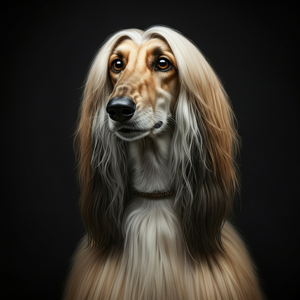

In [29]:
image.resize((300,300))

### Create Local Embeddings DB - With Numpy

The data is already stored in the dictionary structure of `breed_data`.  This section builds a vertical list of the location and embeddings info: [breed group index, breed index, text embedding, image embedding].  Then Numpy arrays are constructed from the text, image and combined text+image embeddings.

In [30]:
vector_lookup = []
for g, group in enumerate(breed_data):
    for b, breed in enumerate(group['breeds']):
        vector_lookup.append([g, b, breed['text_embedding'], breed['image_embedding']])

In [31]:
text_db = np.array([row[2] for row in vector_lookup])
image_db = np.array([row[3] for row in vector_lookup])

In [32]:
text_db.shape

(118, 1408)

In [33]:
image_db.shape

(118, 1408)

### Generate A Composite Image - Sprite

Some of the embedding visualization use below can use images to represent vectors.  These methods use a composite image rather than individual images.  The section create a composite image, or a grid images, for a fixed square size.  The images are in the order of the embedding across rows and down columns.

In [126]:
thumb_size = 150
n_thumb = len(vector_lookup)
sprite_grid = np.ceil(np.sqrt(n_thumb)).astype(int)
sprite_width = sprite_grid * thumb_size
sprite_height = sprite_grid * thumb_size

In [127]:
sprite = PIL.Image.new(
    mode = 'RGBA',
    size = (sprite_width, sprite_height),
    color = (0, 0, 0, 0)
)

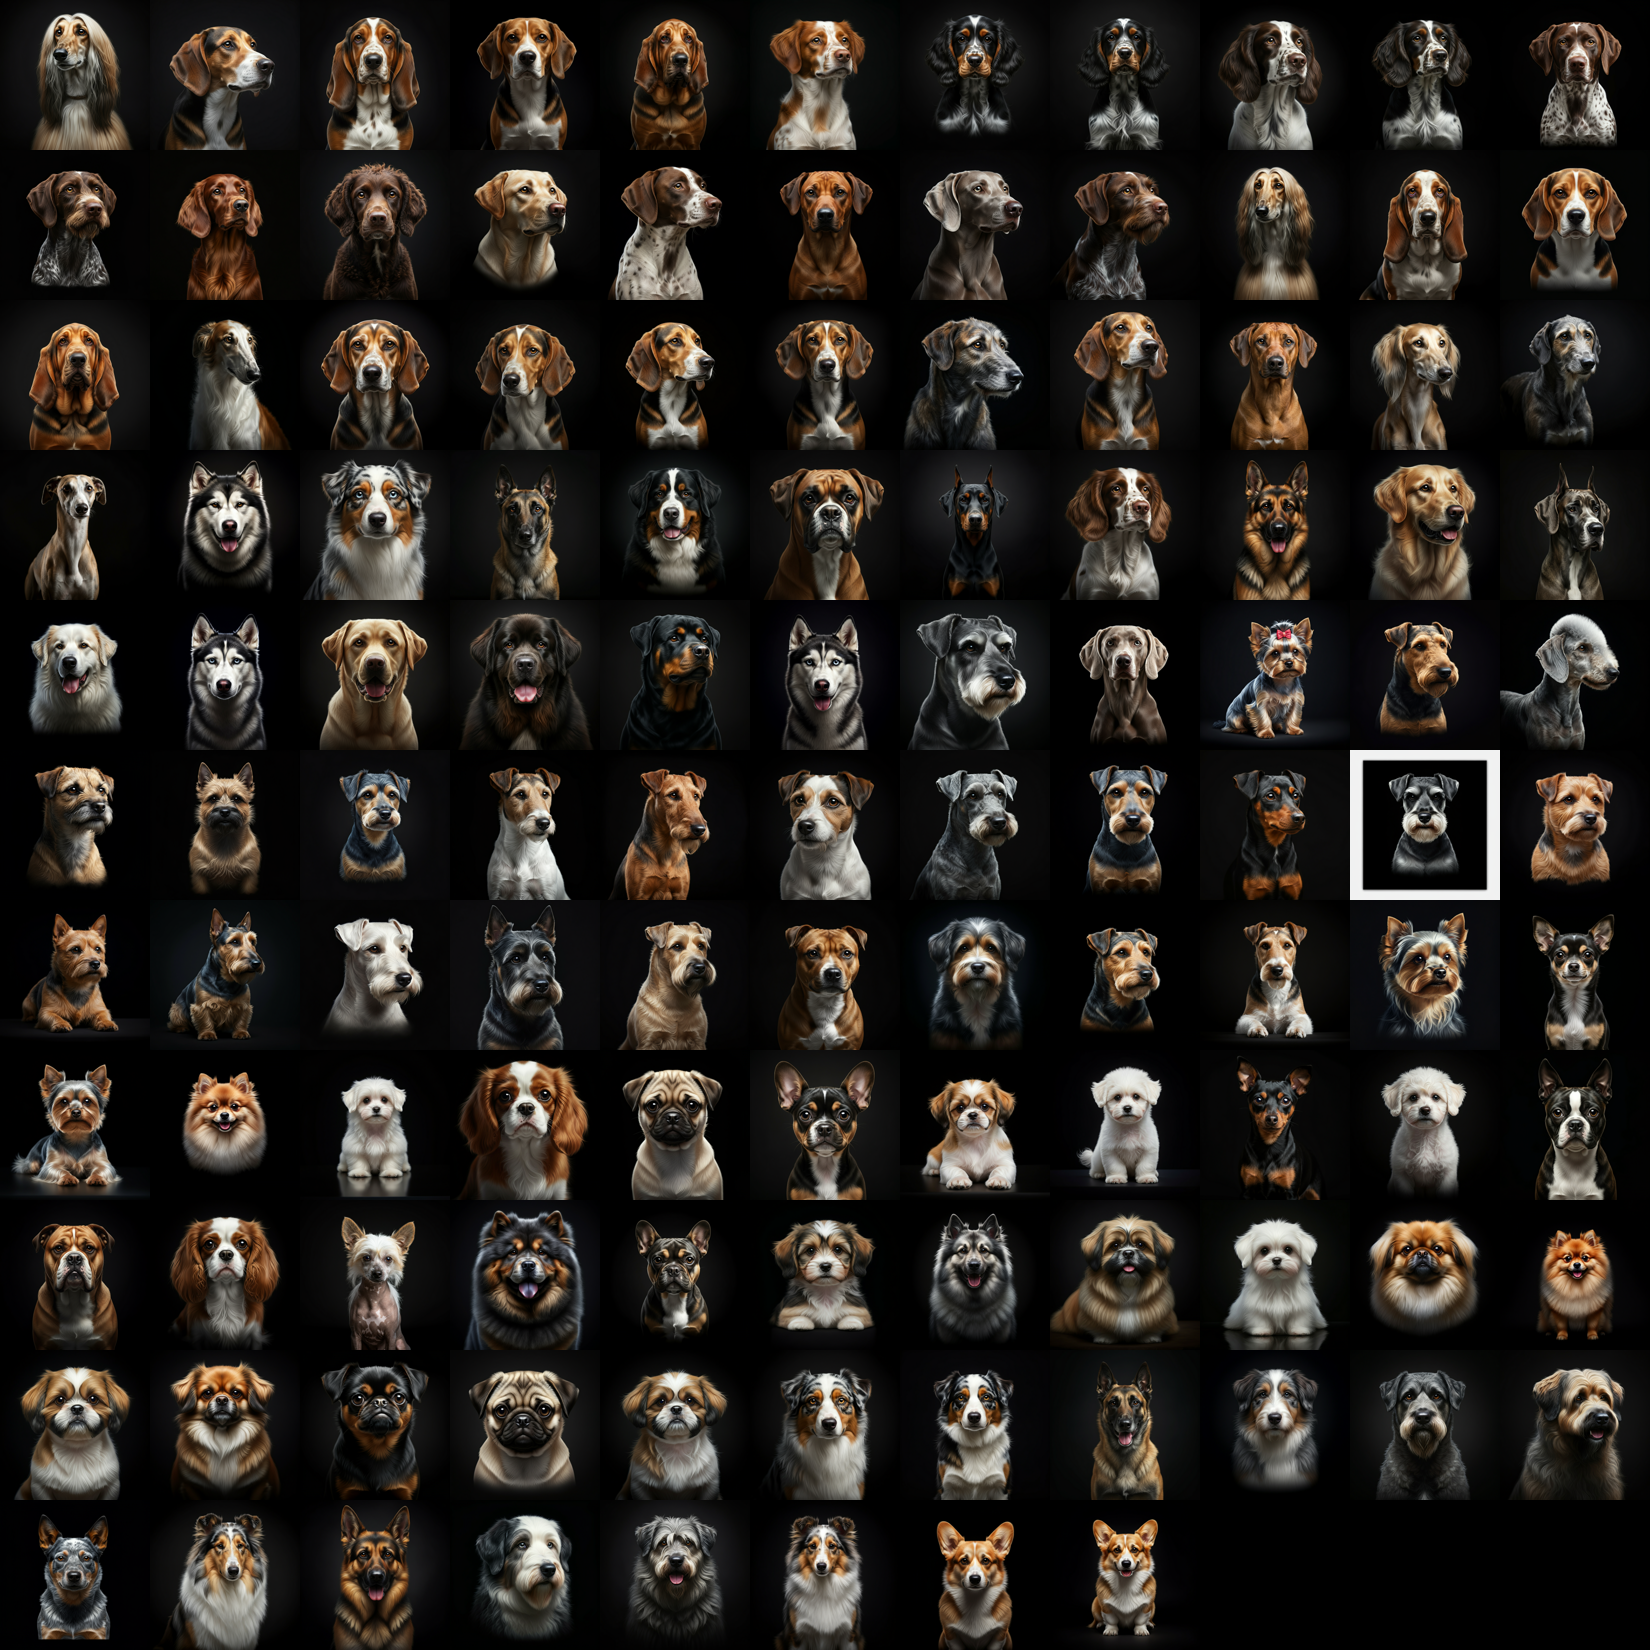

In [128]:
for v, vector in enumerate(vector_lookup):
    in_image = PIL.Image.open(
        io.BytesIO(
            base64.b64decode(
                breed_data[vector[0]]['breeds'][vector[1]]['image_string']
            )
        )
    )
    in_image = in_image.resize((thumb_size, thumb_size))
    sprite.paste(
        in_image,
        (
            thumb_size * (v % sprite_grid),
            thumb_size * (v // sprite_grid)
        )
    )
sprite = sprite.convert("RGB")
sprite

---
## Visualize Embeddings: Single

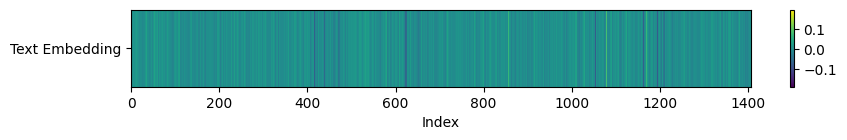

In [90]:
plt.figure(figsize=(10, 1))
plt.imshow([vector_lookup[0][2]], cmap='viridis', aspect='auto')
plt.xlabel('Index')
plt.yticks([0], ["Text Embedding"]) 
plt.colorbar()
plt.show()

---
## Visualize Embeddings: Compare

### Compare Two Embeddings

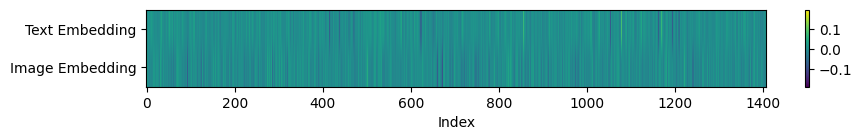

In [91]:
a = vector_lookup[0][2].copy()
b = vector_lookup[0][3].copy()

plt.figure(figsize=(10, 1))
plt.imshow([a, b], cmap='viridis', aspect='auto')
plt.xlabel('Index')
plt.yticks([0, 1], ["Text Embedding", "Image Embedding"]) 
plt.colorbar()
plt.show()

### Compare Two Embeddings And Absolute DIfferences

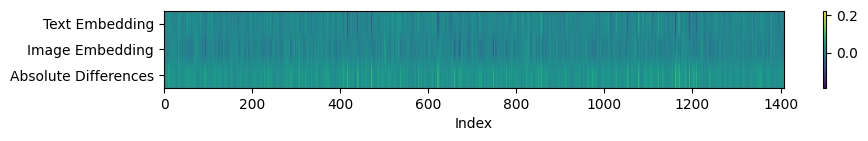

In [92]:
diffs = [abs(x - y) for x, y in zip(a, b)]
    
plt.figure(figsize=(10, 1))
plt.imshow([a, b, diffs], cmap='viridis', aspect='auto')
plt.xlabel('Index')
plt.yticks([0, 1, 2], ["Text Embedding", "Image Embedding", "Absolute Differences"]) 
plt.colorbar()
plt.show()

### Compare Embeddings With Absolute Differences: Subset of Range

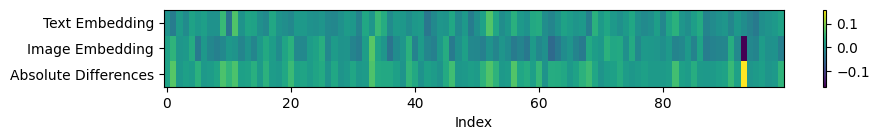

In [93]:
show_range = list(range(100))
plt.figure(figsize=(10, 1))
plt.imshow([[a[i] for i in show_range], [b[i] for i in show_range], [diffs[i] for i in show_range]], cmap='viridis', aspect='auto')
plt.xlabel('Index')
plt.yticks([0, 1, 2], ["Text Embedding", "Image Embedding", "Absolute Differences"]) 
plt.colorbar()
plt.show()

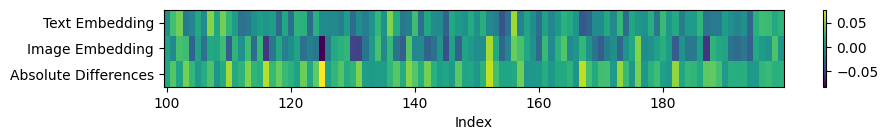

In [94]:
show_range = list(range(100, 200))
plt.figure(figsize=(10, 1))
plt.imshow([[a[i] for i in show_range], [b[i] for i in show_range], [diffs[i] for i in show_range]], cmap='viridis', aspect='auto')
plt.xlabel('Index')
plt.yticks([0, 1, 2], ["Text Embedding", "Image Embedding", "Absolute Differences"]) 
plt.xticks(list(range(len(show_range)))[0::20], show_range[0::20])
plt.colorbar()
plt.show()

---
## Reduction with t-sne

Reduce the dimensions of the embeddings to 2 for visualizaiton using the `t-sne` algorithm.

**References:**
- [scikit-learn: `sklearn.manifold.TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [103]:
text_db = np.array([v[2] for v in vector_lookup])
tsne = sklearn.manifold.TSNE(random_state=0, max_iter=1000, init = 'pca', learning_rate = 'auto')
tsne_results = tsne.fit_transform(text_db)

In [106]:
df_tsne = pd.DataFrame(data = tsne_results, columns = ["TSNE1", "TSNE2"])

(-7.522904896736145, 9.749966645240784, -6.98079924583435, 9.079537916183472)

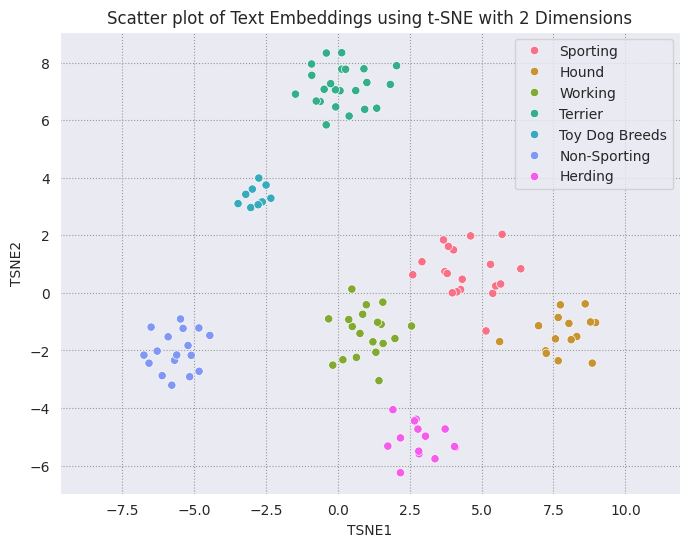

In [120]:
group_labels = [breed_data[v[0]]['name'] for v in vector_lookup]

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2', hue=group_labels, palette='husl') # husl, hls, Set2
plt.title("Scatter plot of Text Embeddings using t-SNE with 2 Dimensions")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

---
## Reduction With PCA

Reduce the dimensions of the embeddings to 2 for visualizaiton using the PCA algorithm.

**References:**
- [scikit-learn: `sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [109]:
text_db = np.array([v[2] for v in vector_lookup])
pca = sklearn.decomposition.PCA(n_components=2, random_state=0)
pca_results = pca.fit_transform(text_db)

In [110]:
df_pca = pd.DataFrame(data=pca_results, columns=["PC1", "PC2"])

(-0.45504423582715126,
 0.45049297181959047,
 -0.3813259215845821,
 0.41589796661301875)

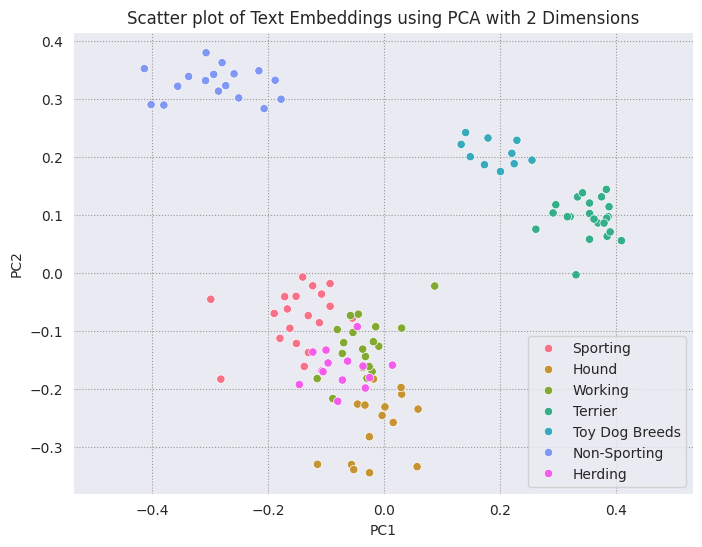

In [119]:
group_labels = [breed_data[v[0]]['name'] for v in vector_lookup]

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"}) 
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=group_labels, palette='husl') # husl, hls, Set2

# Add title and labels
plt.title("Scatter plot of Text Embeddings using PCA with 2 Dimensions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axis("equal")

## Embeddings Projector: Tensorboard In Notebook

https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin

In [134]:
# set a local path to hold tensorboard data:
log_dir = DIR + '/tensorboard/logs/embeddings'

# create metadata for text and image embeddings:
sprite.save(os.path.join(log_dir, 'sprite.jpg'), transparency = 0)
with open(log_dir + '/text_metadata.tsv', 'w') as f:
    f.write("Group\tBreed\n")
    for breed in vector_lookup:
        f.write(f"{breed_data[breed[0]]['name']}\t{breed_data[breed[0]]['breeds'][breed[1]]['name']}\n")
with open(log_dir + '/image_metadata.tsv', 'w') as f:
    f.write("Group\tBreed\n")
    for breed in vector_lookup:
        f.write(f"{breed_data[breed[0]]['name']}\t{breed_data[breed[0]]['breeds'][breed[1]]['name']}\n")

# save embedding data to path:
checkpoint = tf.train.Checkpoint(
    text = tf.Variable(text_db),
    image = tf.Variable(image_db)
)
checkpoint.save(log_dir +'/embeddings.ckpt')

# configure projector
config = projector.ProjectorConfig()
e1 = config.embeddings.add()
e1.tensor_name = 'text/.ATTRIBUTES/VARIABLE_VALUE'
e1.metadata_path = 'text_metadata.tsv'
e2 = config.embeddings.add()
e2.tensor_name = 'image/.ATTRIBUTES/VARIABLE_VALUE'
e2.metadata_path = 'image_metadata.tsv'
e2.sprite.image_path = 'sprite.jpg'
e2.sprite.single_image_dim.extend((thumb_size, thumb_size))

projector.visualize_embeddings(log_dir, config)

In [ ]:
%tensorboard --logdir files/visualize-embeddings/tensorboard/logs/embeddings

## Embeddings Projector: `http://projector.tensorflow.org`

You can load data with `http://projector.tensorflow.org` as long as it is in public locations (like GitHub).  You can even load directly from your computer within the interface.

Load data directly by loading the website with `/?config=https://path/to/config.json` where `config.json` is like the `projector_config.pbtxt` file created in the section above for local Tensorboard.

### Create `projector_config.json`

In [138]:
# update this prefix to the repository you are working in:
repo_raw_prefix = 'https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20GenAI/Embeddings'

In [139]:
with open(os.path.join(log_dir, 'text_embeddings.tsv'), 'w') as f:
    for v in vector_lookup:
        f.write("\t".join(map(str, v[2]))+'\n')
with open(os.path.join(log_dir, 'image_embeddings.tsv'), 'w') as f:
    for v in vector_lookup:
        f.write("\t".join(map(str, v[3]))+'\n')

In [140]:
projector_config = dict(
    embeddings = [
        dict(
            tensorName = 'Text Embeddings',
            tensorShape = [len(vector_lookup), len(vector_lookup[0][2])],
            tensorPath = f"{repo_raw_prefix}/{log_dir}/text_embeddings.tsv",
            metadataPath = f"{repo_raw_prefix}/{log_dir}/text_metadata.tsv"
        ),
        dict(
            tensorName = 'Image Embeddings',
            tensorShape = [len(vector_lookup), len(vector_lookup[0][3])],
            tensorPath = f"{repo_raw_prefix}/{log_dir}/image_embeddings.tsv",
            metadataPath = f"{repo_raw_prefix}/{log_dir}/image_metadata.tsv",
            sprite = dict(
                imagePath = f"{repo_raw_prefix}/{log_dir}/sprite.jpg",
                singleImageDim = [thumb_size, thumb_size]
            )
        )
    ]
)

In [141]:
with open(os.path.join(log_dir, 'projector_config.json'), 'w') as f:
    json.dump(projector_config, f)

In [142]:
print(f"http://projector.tensorflow.org/?config={repo_raw_prefix}/{log_dir}/projector_config.json")

http://projector.tensorflow.org/?config=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20GenAI/Embeddings/files/visualize-embeddings/tensorboard/logs/embeddings/projector_config.json
